In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [11]:
# How many dates are recorded?
session.query(func.count(measurement.date)).all()

[(19550)]

In [12]:
# Calculate the date 1 year ago from the last data point in the database

earliest_date = session.query(measurement.date).order_by(measurement.date).first()
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"Earliest: {earliest_date[0]} , Latest: {latest_date[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12 = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
query_date = dt.date(last_12.year -1, last_12.month, last_12.day)
query_date

# Perform a query to retrieve the data and precipitation scores
data_and_precipitation_scores = [measurement.date,measurement.prcp]
query_result = session.query(*data_and_precipitation_scores).filter(measurement.date >= query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date
precipitation = pd.DataFrame(query_result, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any') 
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


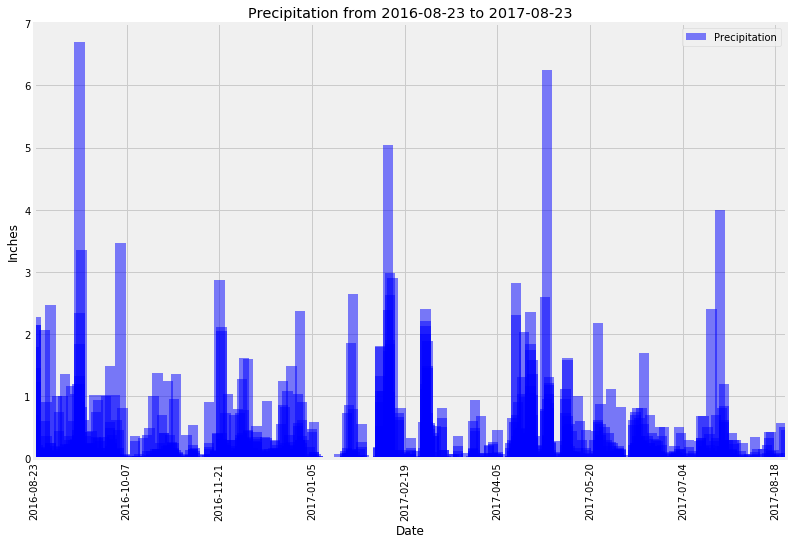

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = precipitation.index.tolist()
y_axis = precipitation["Precipitation"].tolist()

plt.figure(figsize=(12,8))
plt.bar(x_axis, y_axis,width=5, color='b',alpha=0.5, align="center", label='Precipitation')
ticks = np.arange(0,400,45)
plt.xticks(ticks, rotation=90)
plt.xlim("2016-08-23","2017-08-23")
plt.ylim(0,7)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.title(f"Precipitation from {query_date} to {latest_date[0]}")
plt.savefig("Images/precipitation1.png")
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(station.id).count()


9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
data_and_precipitation_scores = [measurement.station,func.count(measurement.id)]
active_stations = session.query(*data_and_precipitation_scores).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
data_and_precipitation_scores = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
most_active_station_data = session.query(*data_and_precipitation_scores).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
most_active_station_data


(54.0, 85.0, 71.66378066378067)

In [19]:
# Choose the station with the highest number of temperature observations.

query_result = session.query(measurement.tobs).\
    filter(measurement.station == active_stations[0][0]).\
    filter(measurement.date >= query_date).all()
temperatures = list(np.ravel(query_result))

data_and_precipitation_scores = [station.station,station.name,station.latitude,station.longitude,station.elevation]
query_result = session.query(*data_and_precipitation_scores).all()
stations_desc = pd.DataFrame(query_result, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_temp = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]

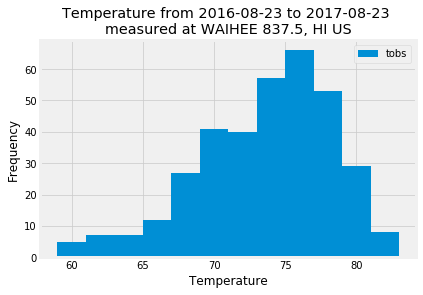

In [20]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f"Temperature from {query_date} to {latest_date[0]} \nmeasured at {station_temp}")
plt.savefig("Images/histogram1.png")
plt.legend()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
"""TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
begin_date = '2017-01-01'
end_date = '2017-01-07'
temp_result = calc_temps(begin_date,end_date)[0]
temp_result


(62.0, 68.36585365853658, 74.0)

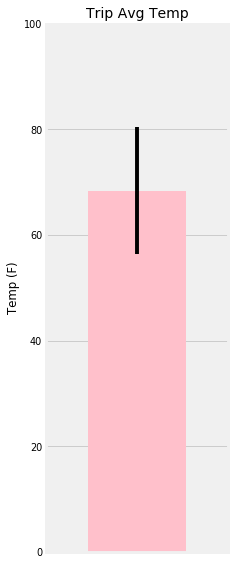

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = [0]
y_pos = [temp_result[1]]
error = [(temp_result[2] - temp_result[0])]

w = 3
h = 10
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='pink', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.savefig("Images/average.png")
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
begindate = '2017-01-01'
end_date = '2017-01-07'

data_and_precipitation_scores = [station.station,station.name,station.latitude,station.longitude,station.elevation,func.sum(measurement.prcp)]
query_result = session.query(*data_and_precipitation_scores).\
    filter(station.station == measurement.station).\
    group_by(measurement.station).\
    filter(measurement.date >= begin_date).\
    filter(measurement.date <= end_date).\
    order_by(func.sum(measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(query_result, columns=['Station','Name','Latitude','Longitude','Elevation','Precipitation Amount'])
stations


,Station,Name,Latitude,Longitude,Elevation,Precipitation Amount
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    data_and_precipitation_scores = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*data_and_precipitation_scores).filter(func.strftime("%m-%d", measurement.date) == date).all()
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-01-01'
last_date = '2018-01-07'

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings
start_date_obj = dt.datetime.strptime(start_date, '%Y-%m-%d')
last_date_obj = dt.datetime.strptime(last_date, '%Y-%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates = []
normals =[]
while (start_date_obj <= last_date_obj):
    trip_dates.append(dt.datetime.strftime(start_date_obj,'%Y-%m-%d'))
    date_start = dt.datetime.strftime(start_date_obj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(date_start))))
    start_date_obj = start_date_obj + dt.timedelta(days = 1)

normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
previous_results = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
previous_results['Date'] = trip_dates
previous_results = previous_results.set_index("Date")
previous_results

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


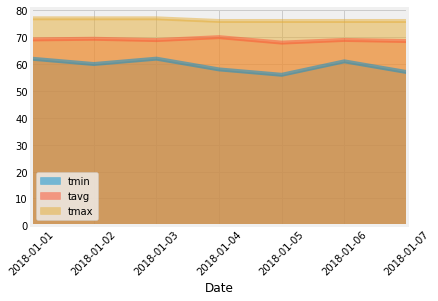

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
previous_results.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.savefig("Images/stacked.png")